# 利用 AWS SageMaker BlazingText 对不均衡文本进行多分类

## 方案概述

在样本不均衡问题上，使用了回译和 EDA 两个方法对少类别样本进行了过采样处理，其中回译方法调用了 AWS Translate 服务进行了翻译再翻译，而 EDA 方法主要使用同义词替换、随机插入、随机交换、随机删除对文本数据进行处理。 本文也使用了AWS SageMaker 的自动超参数优化来为 BlazingText 的文本分类算法找到最优超参数。

本文使用基于 DBpedia 的公开数据集处理生成的含有14个类别的不均衡文本数据，并进行了不做任何样本不均衡处理的 Baseline 实验和包含回译和 EDA 两个方法的过采样实验。

在这个案例中，使用的数据集是根据文章的标题和摘要进行作者的多分类。然而，本文提出的文本分类方法适用于任何样本不均衡的文本分类场景，比如：

1. 垃圾邮件分类，实际数据中只有少部分邮件是垃圾邮件；
2. 根据诊断报告疾病预测，真实的临床数据中也只有少部分数据真的患有某种疾病；
3. 新闻分类，对网站的大量新闻进行分类判断是属于经济的，还是文化的等，但是不同网站类别偏差较大，比如娱乐网站娱乐新闻偏多，但是也会有其他类别的新闻。

## 准备

1. 启动一个 ml.c5.xlarge 或者 ml.m5.xlarge 的 SageMaker Notebook instance
2. Notebook instance准备一个 IAM role: 本案例需要调用 S3 以及 Translate，因此需要给该 IAM role 赋予 S3FullAccess 和 TranslateFullAccess 两个权限。


## 下载并生成不均衡数据集
1. 下载 DBpedia 的原始数据集，一共有14个类别，对每个类别就进行随机取样，最后生成一个不均衡的包含14个类别的数据集。

In [16]:
import pandas as pd
import sagemaker
from sagemaker import get_execution_role
import json
import boto3
from random import shuffle

sess = sagemaker.Session()

role = get_execution_role()
print(role) # This is the role that SageMaker would use to leverage AWS resources (S3, CloudWatch) on your behalf

bucket = 'ray-ai-ml-bjs' #sess.default_bucket() # Replace with your own bucket name if needed
input_prefix = 'classification/blazingtext/UnbalancedTextMulticlassification'
file_name = 'dbpedia_csv.tar.gz'

s3 = boto3.client('s3')
s3.download_file(bucket, input_prefix+'/'+file_name, file_name)

#!wget https://github.com/saurabh3949/Text-Classification-Datasets/raw/master/dbpedia_csv.tar.gz
#sess.upload_data(path='dbpedia_csv.tar.gz', bucket=bucket, key_prefix=input_prefix)

arn:aws-cn:iam::876820548815:role/Sagemaker-Bootcamp-SageMakerExecutionRole-Z3VF78G260T1


2. 预览数据

In [17]:
!tar -xzvf dbpedia_csv.tar.gz

origin_df = pd.read_csv('dbpedia_csv/train.csv')
print("行数：" + str(origin_df.shape[0]))
#print(origin_df[0:5])
origin_df.head(5)

dbpedia_csv/
dbpedia_csv/train.csv
dbpedia_csv/test.csv
dbpedia_csv/readme.txt
dbpedia_csv/classes.txt
行数：560000
   label                              title  \
0      1                   E. D. Abbott Ltd   
1      1                     Schwan-Stabilo   
2      1                         Q-workshop   
3      1  Marvell Software Solutions Israel   
4      1        Bergan Mercy Medical Center   

                                            abstract  
0   Abbott of Farnham E D Abbott Limited was a Br...  
1   Schwan-STABILO is a German maker of pens for ...  
2   Q-workshop is a Polish company located in Poz...  
3   Marvell Software Solutions Israel known as RA...  
4   Bergan Mercy Medical Center is a hospital loc...  


,label,title,abstract
0,1,E. D. Abbott Ltd,Abbott of Farnham E D Abbott Limited was a Br...
1,1,Schwan-Stabilo,Schwan-STABILO is a German maker of pens for ...
2,1,Q-workshop,Q-workshop is a Polish company located in Poz...
3,1,Marvell Software Solutions Israel,Marvell Software Solutions Israel known as RA...
4,1,Bergan Mercy Medical Center,Bergan Mercy Medical Center is a hospital loc...


3. 查看一共有哪些类别以及每个类别数据的数量分布情况

In [19]:
count_classes = pd.value_counts(origin_df['label'], sort = True)
print(count_classes)

grouped = origin_df.groupby('label')
new_df = grouped.get_group(1)

14    40000
13    40000
12    40000
11    40000
10    40000
9     40000
8     40000
7     40000
6     40000
5     40000
4     40000
3     40000
2     40000
1     40000
Name: label, dtype: int64


4. 对每个label随机取样，构造偏移

In [20]:
grouped = origin_df.groupby('label')
new_df = grouped.get_group(1)

# 对每个label随机取样
group2 = grouped.get_group(2)
new_group2 = group2.sample(n=38000)

group3 = grouped.get_group(3)
new_group3 = group3.sample(n=18000)

group4 = grouped.get_group(4)
new_group4 = group4.sample(n=17000)

group5 = grouped.get_group(5)
new_group5 = group5.sample(n=16000)

group6 = grouped.get_group(6)
new_group6 = group6.sample(n=15000)

group7 = grouped.get_group(7)
new_group7 = group7.sample(n=14000)

group8 = grouped.get_group(8)
new_group8 = group8.sample(n=13000)

group9 = grouped.get_group(9)
new_group9 = group9.sample(n=8000)

group10 = grouped.get_group(10)
new_group10 = group10.sample(n=5000)

group11 = grouped.get_group(11)
new_group11 = group11.sample(n=3000)

group12 = grouped.get_group(12)
new_group12 = group12.sample(n=900)

group13 = grouped.get_group(13)
new_group13 = group13.sample(n=100)

group14 = grouped.get_group(14)
new_group14 = group14.sample(n=20)

new_df = new_df.append(new_group2)
new_df = new_df.append(new_group3)
new_df = new_df.append(new_group4)
new_df = new_df.append(new_group5)
new_df = new_df.append(new_group6)
new_df = new_df.append(new_group7)
new_df = new_df.append(new_group8)
new_df = new_df.append(new_group9)
new_df = new_df.append(new_group10)
new_df = new_df.append(new_group11)
new_df = new_df.append(new_group12)
new_df = new_df.append(new_group13)
new_df = new_df.append(new_group14)

print("行数：" + str(new_df.shape[0]))

new_count_classes = pd.value_counts(new_df['label'], sort = True)
print(new_count_classes)

行数：188020
1     40000
2     38000
3     18000
4     17000
5     16000
6     15000
7     14000
8     13000
9      8000
10     5000
11     3000
12      900
13      100
14       20
Name: label, dtype: int64


5. 查看数据集的类别分布情况，包括每个类别的数量，并画好分布图。

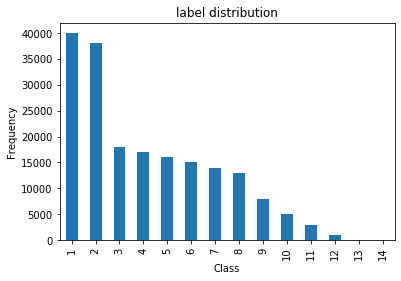

In [22]:
import matplotlib.pyplot as plt

count_classes = new_df.label.value_counts()
count_classes.plot(kind = 'bar')
plt.title("label distribution")
plt.xlabel("Class")
plt.ylabel("Frequency");

6. 保存处理后的不均衡数据集

In [25]:
import os

os.mkdir('unblance_original_dataset') 
new_df.to_csv("unblance_original_dataset/dataset.csv", index=0)

from shutil import copyfile

copyfile("dbpedia_csv/classes.txt", "unblance_original_dataset/classes.txt")

'unblance_original_dataset/classes.txt'

# 下面执行baseline实现，运行text_multi_classification_baseline.ipynb